In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/speech emotion detection
#%cd /dataset

/content/drive/.shortcut-targets-by-id/1cx4Sc4HGMkc07leKsV-1yLgQaB97j8rh/speech emotion detection


## Import Libraries

In [3]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import cv2
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
import IPython.display as ipd
import random
from patchify import patchify
from tensorflow.keras.applications import VGG19
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D,Convolution2D, MaxPooling2D, ZeroPadding2D,MaxPooling1D,ZeroPadding1D

## import data

>> this dataset is taken from the keggle which actually contain different voices of 24 actors representing different emotions. Here is the link for the dataset: [Click Here](https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition/data)

In [5]:
images = []
images_name = []
folders  =  list(os.listdir("dataset/"))
folders = folders[:-3]


In [6]:
folders 

['Actor_03',
 'Actor_02',
 '.ipynb_checkpoints',
 'Actor_01',
 'Actor_07',
 'Actor_05',
 'Actor_04',
 'Actor_06',
 'Actor_11',
 'Actor_09',
 'Actor_08',
 'Actor_10',
 'Actor_13',
 'Actor_15',
 'Actor_14',
 'Actor_12',
 'Actor_16',
 'Actor_17',
 'Actor_19',
 'Actor_21',
 'Actor_18',
 'Actor_20',
 'Actor_22',
 'Actor_24']

In [ ]:
#generating the spectrograms for all the voice nodes 
'''
try:
    os.makedirs('Images')
except FileExistsError:
    pass
for i in tqdm(range(len(folders))):
    files = os.listdir(os.getcwd() + "//" +folders[i])
    files = [i for i in files if i.endswith('.wav')]
    try:
        os.makedirs(f'Images//{folders[i]}')
    except FileExistsError:
        pass
    for j in range(len(files)):
        images_name.append(folders[i]+"//"+files[j])
        x, sr = librosa.load(f'{os.getcwd()}//{folders[i]}//{files[j]}', sr=44100)
        X = librosa.stft(x)
        Xdb = librosa.amplitude_to_db(abs(X))
        librosa.display.specshow(Xdb)
        #plt.colorbar()
        #print(i,j)
        
        plt.savefig(f'{os.getcwd()}//Images//{folders[i]}//{files[j]}'[:-3]+'png')
        plt.close() 
'''

'\ntry:\n    os.makedirs(\'Images\')\nexcept FileExistsError:\n    pass\nfor i in tqdm(range(len(folders))):\n    files = os.listdir(os.getcwd() + "//" +folders[i])\n    files = [i for i in files if i.endswith(\'.wav\')]\n    try:\n        os.makedirs(f\'Images//{folders[i]}\')\n    except FileExistsError:\n        pass\n    for j in range(len(files)):\n        images_name.append(folders[i]+"//"+files[j])\n        x, sr = librosa.load(f\'{os.getcwd()}//{folders[i]}//{files[j]}\', sr=44100)\n        X = librosa.stft(x)\n        Xdb = librosa.amplitude_to_db(abs(X))\n        librosa.display.specshow(Xdb)\n        #plt.colorbar()\n        #print(i,j)\n        \n        plt.savefig(f\'{os.getcwd()}//Images//{folders[i]}//{files[j]}\'[:-3]+\'png\')\n        plt.close() \n'

# Reading Audio Images

In [7]:

for i in range(len(folders)):
    files = os.listdir(os.getcwd() + "/dataset/"+folders[i])
    files = [i for i in files if i.endswith('.wav')]

    for j in range(len(files)):
      images_name.append(folders[i]+"//"+files[j])

In [8]:
#reading all the spectograms images
images = []
for i in range(len(images_name)):
    images.append(cv2.imread(os.getcwd() +"//dataset//Images//"+ images_name[i][:-3] +"png")[42:250, 54:380]) 

In [9]:
images[0].shape

(208, 326, 3)

# Normalizing Data

In [11]:
images = np.array(images, dtype=np.float32) / 255
images.shape

(1380, 208, 326, 3)

# Reading the labels for the voice nodes's emotions

In [12]:
y = []
df = pd.DataFrame(columns=['Modality','Vocal channel','Emotion','Emotional intensity','Statement','Repetition','Actor'], index= range(len(images_name)))
for i in range(len(images_name)):
    split_list = images_name[i].split('-')
    split_list[-1] = split_list[-1][:2] 
    split_list[0] =  split_list[0][-2:]
    df.iloc[i] = split_list
    y.append(int(images_name[i].split('-')[2]))
df.drop(columns = ['Modality','Vocal channel','Emotion'], inplace = True)

In [13]:
obj_cols = df.loc[:, df.dtypes == np.object].columns
for col in obj_cols:
     df[col] = pd.to_numeric(df[col])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [14]:
#one hot-encoding the labels
y = pd.get_dummies(y)

In [15]:
y.head()

,1,2,3,4,5,6,7,8
0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.20,random_state=42)

In [17]:
pd.DataFrame(y_train).value_counts()

1  2  3  4  5  6  7  8
0  0  0  1  0  0  0  0    156
      1  0  0  0  0  0    156
      0  0  1  0  0  0    150
   1  0  0  0  0  0  0    146
   0  0  0  0  0  1  0    145
               1  0  0    142
               0  0  1    133
1  0  0  0  0  0  0  0     76
dtype: int64

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Masking
model1 = Sequential()
# model1.add(Masking(mask_value=1.0))
model1.add(ZeroPadding2D((1,1),input_shape=np.array(X_train)[0].shape))
model1.add(Convolution2D(8, 3, 3, activation='relu',kernel_regularizer=regularizers.l2(l=0.01)))
model1.add(ZeroPadding2D((1,1)))
model1.add(Convolution2D(8, 3, 3, activation='relu',kernel_regularizer=regularizers.l2(l=0.01)))
model1.add(MaxPooling2D((2,2),  padding='same'))
model1.add(Dropout(0.3))

model1.add(Convolution2D(64, 3, 3, activation='relu'))
model1.add(MaxPooling2D((2,2),  padding='same'))

model1.add(ZeroPadding2D((1,1)))
model1.add(Convolution2D(128, 3, 3, activation='relu'))

# model1.add(ZeroPadding2D((1,1)))
# model1.add(Convolution2D(128, 3, 3, activation='relu',kernel_regularizer=regularizers.l2(l=0.1)))
# model1.add(Dropout(0.1))

model1.add(MaxPooling2D((2,2), padding='same'))


model1.add(Flatten())
model1.add(Dense(1024, activation='relu'))

model1.add(Dense(128, activation='relu'))

model1.add(Dense(8, activation='relu'))

In [18]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, Dropout, BatchNormalization

def build_deep_cnn(number_of_output, input_shape):
    
    model_cnn = keras.Sequential()
    model_cnn.add(Input(input_shape))
    
    model_cnn.add(Conv2D(32, kernel_size=(3,3), padding='same', activation="relu"))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(32, kernel_size=(3,3), padding='same', activation="relu"))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D(pool_size=(2,2)))
    model_cnn.add(Dropout(0.2))


    model_cnn.add(Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D(pool_size=(2,2)))
    model_cnn.add(Dropout(0.3))


    model_cnn.add(Conv2D(128, kernel_size=(3,3), padding='same', activation="relu"))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(128, kernel_size=(3,3), padding='same', activation="relu"))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D(pool_size=(2,2)))
    model_cnn.add(Dropout(0.4))


  
    model_cnn.add(Flatten())
    model_cnn.add(Dense(2048, activation='relu'))
    model_cnn.add(Dense(1024, activation='relu'))
    model_cnn.add(Dense(512, activation='relu'))

    #output layer for classification
    model_cnn.add(Dense(number_of_output, activation='softmax'))
    
    model_cnn.compile(optimizer= tf.optimizers.Adam(),
                      loss=keras.losses.categorical_crossentropy,
                      metrics='accuracy')
    return model_cnn

In [19]:
input_shape = images[0].shape
number_of_output = 8
model = build_deep_cnn(number_of_output=number_of_output, input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 208, 326, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 208, 326, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 208, 326, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 208, 326, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 104, 163, 32)     0         
 )                                                               
                                                        

In [21]:
h = model.fit(X_train, y_train,
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test), batch_size=20)

Epoch 1/50
56/56 [==============================] - 12s 214ms/step - loss: 1.5975 - accuracy: 0.4502 - val_loss: 9.3613 - val_accuracy: 0.1014
Epoch 2/50
56/56 [==============================] - 12s 210ms/step - loss: 1.3990 - accuracy: 0.4819 - val_loss: 11.6907 - val_accuracy: 0.1377
Epoch 3/50
56/56 [==============================] - 12s 212ms/step - loss: 1.4798 - accuracy: 0.4774 - val_loss: 12.1822 - val_accuracy: 0.1377
Epoch 4/50
56/56 [==============================] - 12s 214ms/step - loss: 1.4807 - accuracy: 0.4792 - val_loss: 10.5194 - val_accuracy: 0.1014
Epoch 5/50
56/56 [==============================] - 12s 215ms/step - loss: 1.3537 - accuracy: 0.5335 - val_loss: 6.5184 - val_accuracy: 0.1268
Epoch 6/50
56/56 [==============================] - 12s 215ms/step - loss: 1.2050 - accuracy: 0.5607 - val_loss: 6.6352 - val_accuracy: 0.1268
Epoch 7/50
56/56 [==============================] - 12s 213ms/step - loss: 1.1424 - accuracy: 0.5806 - val_loss: 3.5387 - val_accuracy: 0.1

In [1]:
plt.figure(figsize=(8,5))
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


NameError: ignored

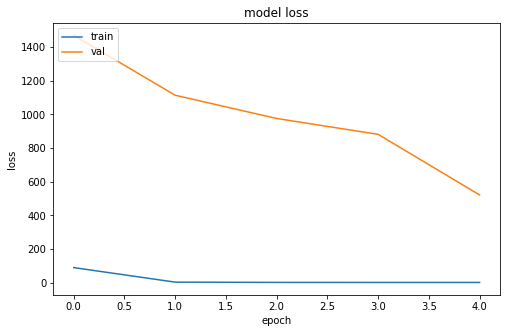

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
test = np.array(y_test)

In [ ]:
y_pred = model.predict(X_test)
y_test2 = []
y_pred2 = []
for i in range(len(y_test)):
    y_pred2.append(np.argmax(y_pred[i]))
    y_test2.append(np.argmax(test[i]))

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy =",accuracy_score(y_pred2,y_test2) * 100)

Accuracy = 14.130434782608695


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test2,y_pred2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        38
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        34
           5       0.00      0.00      0.00        42
           6       0.14      1.00      0.25        39
           7       0.00      0.00      0.00        51

    accuracy                           0.14       276
   macro avg       0.02      0.12      0.03       276
weighted avg       0.02      0.14      0.03       276



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
